Se prueba la mejora del RNN, el LSTM para ver si captura mejor el ejercicio de nlp. En principio son muy similares normalmente
los resultados por experiencia propia anterior, con el lstm siendo mas una solucion al vanishing gradient problem que una mejora 
increible de rendimiento.
Se utilizaran los mismo parametros basicos que en el RNN, con adam y Cross entropy loss, y el bert tokenizer.
Pero viendo que el accuracy del RNN, fue menor que escoger aleatoriamente, 0.4956, entonces casi cualquier mejora seria relevante.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np


dataset = load_dataset('imdb')


def reduce_dataset(dataset, factor=10):
    reduced_dataset = {}
    for split in dataset.keys():
        labels = np.array(dataset[split]['label'])
        num_per_class = (len(labels) // (2 * factor))

        indices_0 = np.where(labels == 0)[0][:num_per_class]
        indices_1 = np.where(labels == 1)[0][:num_per_class]

        indices = np.concatenate([indices_0, indices_1])
        np.random.shuffle(indices)
        

        reduced_dataset[split] = dataset[split].select(indices.tolist())
    return reduced_dataset

reduced_dataset = reduce_dataset(dataset)

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = {}
for split in reduced_dataset.keys():
    tokenized_datasets[split] = reduced_dataset[split].map(tokenize_function, batched=True)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids):
        embedded = self.dropout(self.embedding(input_ids))
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = LSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return input_ids, labels

train_loader = DataLoader(tokenized_datasets['train'], batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(tokenized_datasets['test'], batch_size=8, shuffle=False, collate_fn=collate_fn)


def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for input_ids, labels in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for input_ids, labels in test_loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return total_loss / len(test_loader), accuracy, precision, recall, f1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

torch.save(model.state_dict(), './trained_lstm_model.pt')
tokenizer.save_pretrained('./trained_lstm_model')

def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512).to(device)
    input_ids = inputs['input_ids']
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
        predicted_class = torch.argmax(outputs, dim=1).item()
    return predicted_class
    
text = "This movie was fantastic! I really enjoyed it."
prediction = predict(text)
print(f'Predicted class: {prediction}')

first_example = tokenized_datasets['test'][0]

input_ids = torch.tensor(first_example['input_ids']).unsqueeze(0)
real_label = first_example['label']

input_ids = input_ids.to(device)
model.to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids)
    predicted_label = torch.argmax(outputs, dim=1).item()

print(f'Real label: {real_label}')
print(f'Predicted label: {predicted_label}')


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Epoch 1/5
Train Loss: 0.7019
Validation Loss: 0.6936
Accuracy: 0.5136
Precision: 0.5403
Recall: 0.1824
F1 Score: 0.2727
Epoch 2/5
Train Loss: 0.6806
Validation Loss: 0.6935
Accuracy: 0.5616
Precision: 0.6016
Recall: 0.3648
F1 Score: 0.4542
Epoch 3/5
Train Loss: 0.6402
Validation Loss: 0.6767
Accuracy: 0.5796
Precision: 0.6519
Recall: 0.3416
F1 Score: 0.4483
Epoch 4/5
Train Loss: 0.6037
Validation Loss: 0.8822
Accuracy: 0.5948
Precision: 0.5613
Recall: 0.8680
F1 Score: 0.6817
Epoch 5/5
Train Loss: 0.5510
Validation Loss: 0.6978
Accuracy: 0.6268
Precision: 0.6514
Recall: 0.5456
F1 Score: 0.5938
Predicted class: 0
Real label: 1
Predicted label: 1


No tiene los mejores resultados en ninguna de las metricas particularmente, siendo un modelo algo subpar, pero muy superior al RNN,
al poder aunque sea mejorar desde un resultado aleatorio.
No se comentara sobre f1score etc, al no tener demasiada relevancia en este caso, ya que se ignorara este modelo por uno mejor.

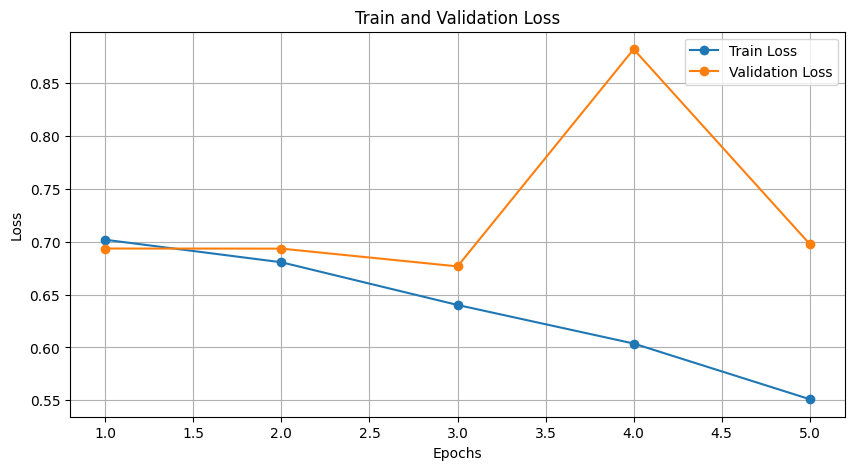

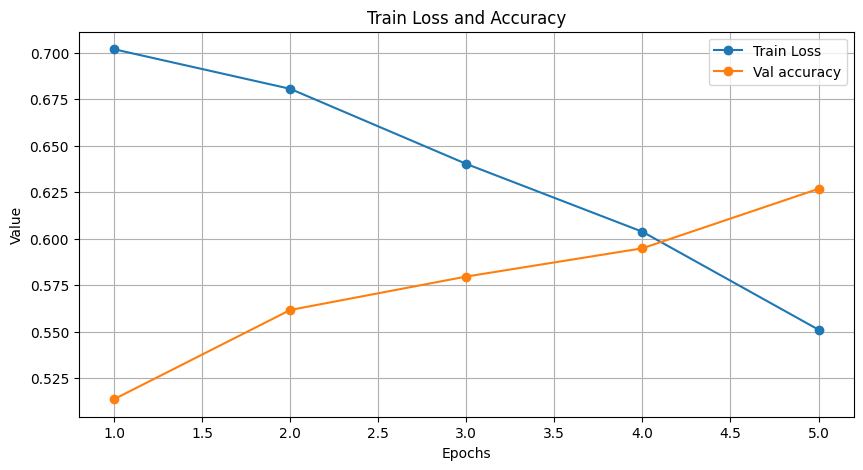

In [5]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5]
train_loss = [0.7019, 0.6806, 0.6402, 0.6037, 0.5510]
val_loss = [0.6936, 0.6935, 0.6767, 0.8822, 0.6978]
accuracy = [0.5136, 0.5616, 0.5796, 0.5948, 0.6268]

# Plotting Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Train Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, accuracy, label='Val accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Train Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Se ven resultados mejores, pero no especialmente buenos, la creciente diferencia entre ambos losses, nos da a creer, que lo mas probable es que si se le dan mas epochs, lo mas probable es que se empieze a generar un sobre-entreno considerable, pero teniendo en cuenta los resultados preliminares, se decidio, que no merecia la pena darle mas epochs, debido a la muy baja precision despues un tiempo de entreno considerable.

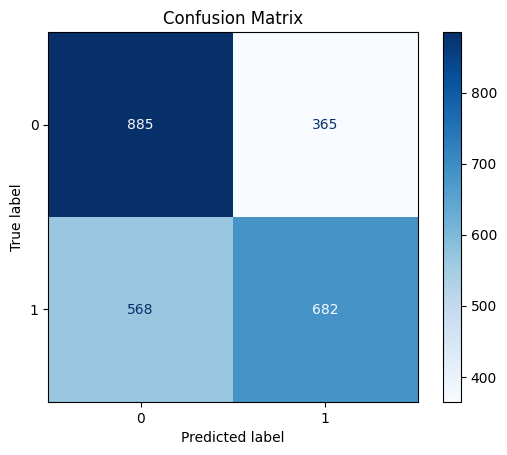

In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return input_ids, labels

test_loader = DataLoader(tokenized_datasets['test'], batch_size=8, shuffle=False, collate_fn=collate_fn)


def get_labels_and_predictions(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for input_ids, labels in test_loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

all_labels, all_preds = get_labels_and_predictions(model, test_loader, device)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


El confusion matrix nos deja ver como tiende a predecir que el input es de label 0, o la label de connotacion negativa. 
Con bastantes mas predicted de esa label, a partir de ahi, no hay mucho que decir, con la representacion siendo mayor en ese label, se ve que por %
acierta un poco mas si predice label 1, pero se podria dar simplemente por la mayor cantidad de predicciones de 0. 
Se buscara mejorar mucho mas la accuracy en el siguiente modelo.